# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

#### Objective:
Given a review, determine whether the review is positive.

<br>

### Assumption 
- We are considering a review a positive one, if it is having rating higher than 3. Similarly we are considering a reviiew as negative, if it is having a rating less than 3.

In [1]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

In [3]:
os.listdir('drive/My Drive/encode-decoder for Logistic Regression/')

['database.sqlite', 'logistic_regression-Encode-Decode.ipynb']

## Importing all the required libraries for data-preprocessing analysis

In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tqdm
import os
import re
import nltk
import string
import sqlite3
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
con = sqlite3.connect('drive/My Drive/encode-decoder for Logistic Regression/database.sqlite')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Name of all the tables in the database : ",cursor.fetchall())

Name of all the tables in the database :  [('Reviews',)]


### Reading the Data from the Database

In [2]:
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 110000""", con) 

In [5]:
score = data['Score'].values ##rating of each review

In [6]:
rating_rev = []
for rating in score:
    if rating<3:
        rating_rev.append(0)
    if rating>3:
        rating_rev.append(1)

In [8]:
data['Score'] = rating_rev
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


##  Data Cleaning: Deduplication
- Removing the duplicate entries from the dataset

In [11]:
#Sorting data based on the ProductId of the product
sorted_data= data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#removing the duplicate entries
sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)
sorted_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,Please do not waste your money. This Fly trap ...


In [14]:
print("Percentage of data remaining after removing duplicate entries: ",(sorted_data['Id'].size*1.0)/(data['Id'].size*1.0)*100)

Percentage of data remaining after removing duplicate entries:  86.69818181818182


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""SELECT *FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final = sorted_data[sorted_data.HelpfulnessNumerator<=sorted_data.HelpfulnessDenominator]

## [3.1].  Preprocessing Review Text

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [20]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
preprocessed_reviews = []
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

# Deviding the data into train-test and cross-validation set

In [26]:
# deviding the review text into train test cv
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.15, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.15, random_state=42)

# Calculating tfidf

In [27]:
## Here we are choosing 6000 features only
tfidf = TfidfVectorizer(max_features=6000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_cv = tfidf.transform(X_cv)

In [29]:
print("Shape of the training dataset after featurization : ", X_train.shape)

Shape of the training dataset after featurization :  (68901, 6000)


### Importing all the required libraries from the keras for dimensionality reduction

In [30]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


### Dimensionality Reduction using Encoder-Decoder 

In [0]:
## Reference : https://towardsdatascience.com/autoencoder-on-dimension-reduction-100f2c98608c
encoding_dim = 2048  # data dimensions after the dimensionality reduction
in_dim = 6000  ## shape of the input feature
# this is our input placeholder
input_img = Input(shape=(in_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(in_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# intermediate result
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
## you can change the optimizer and set the learning rate according to your model, these are hyperparameter
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
## chaning the shape according to the shape required by the model (No need to change in this case)
X_train = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:])))
X_test = X_test.reshape((X_test.shape[0], np.prod(X_test.shape[1:])))
X_cv = X_cv.reshape((X_cv.shape[0],np.prod(X_cv.shape[1:])))

In [138]:
X_train.shape

(68901, 6000)

In [139]:
history = autoencoder.fit(X_train, X_train,epochs=30,batch_size=256,shuffle=True,validation_data = (X_cv, X_cv))

Train on 68901 samples, validate on 12160 samples
Epoch 1/30
68901/68901 [==============================] - 16s 237us/step - loss: 0.0560 - acc: 0.9905 - val_loss: 0.0068 - val_acc: 0.9949
Epoch 2/30
68901/68901 [==============================] - 15s 225us/step - loss: 0.0067 - acc: 0.9948 - val_loss: 0.0065 - val_acc: 0.9949
Epoch 3/30
68901/68901 [==============================] - 15s 225us/step - loss: 0.0064 - acc: 0.9948 - val_loss: 0.0063 - val_acc: 0.9949
Epoch 4/30
68901/68901 [==============================] - 15s 224us/step - loss: 0.0062 - acc: 0.9948 - val_loss: 0.0061 - val_acc: 0.9949
Epoch 5/30
68901/68901 [==============================] - 16s 226us/step - loss: 0.0060 - acc: 0.9948 - val_loss: 0.0059 - val_acc: 0.9949
Epoch 6/30
68901/68901 [==============================] - 16s 226us/step - loss: 0.0058 - acc: 0.9948 - val_loss: 0.0058 - val_acc: 0.9949
Epoch 7/30
68901/68901 [==============================] - 15s 225us/step - loss: 0.0057 - acc: 0.9948 - val_loss: 0.

### Validation vs training accuracy

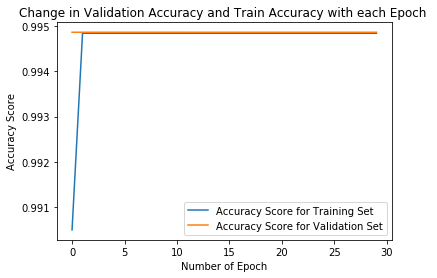

In [141]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Accuracy Score for Training Set','Accuracy Score for Validation Set'])
plt.title("Change in Validation Accuracy and Train Accuracy with each Epoch ")
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy Score")
plt.show()

### predicting the encoded vector using the trained encoder decoder model

In [0]:
enc_X_train = encoder.predict(X_train)
enc_X_val = encoder.predict(X_cv)
enc_X_test = encoder.predict(X_test)

In [143]:
print("Dimensionality of the data after decreasing the dimension of the data using Encoder: ",enc_X_train.shape)

Dimensionality of the data after decreasing the dimension of the data using Encoder:  (68901, 2048)


In [144]:
!pip install scikit-plot

### import all the required libraries for logistic regression model evaluation

In [31]:
from sklearn.linear_model import LogisticRegression as MNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score as AUC
import scikitplot.metrics as skplt
from sklearn.metrics import confusion_matrix

### finding the optimal value of C

In [146]:
alpha = [.0001,.001,.01,.1,1,10,10,100]
alpha1 = np.log(alpha)
roc_auc_cv = []
roc_auc_train = []
opt_c = 0
opt_auc = 0
for i in alpha:
    nv =MNB(C=i,penalty = 'l2')
    nv.fit(enc_X_train,y_train)
    prediction1 = nv.predict_proba(enc_X_val)[:,1]
    score1 = AUC(y_cv,prediction1)
    prediction2 = nv.predict_proba(enc_X_train)[:,1]
    score2 = AUC(y_train,prediction2)
    print(i," ------> ",score1)
    roc_auc_train.append(score2)
    roc_auc_cv.append(score1)
    if(opt_auc<score1):
        opt_auc = score1
        opt_c = i
print("Optimal AUC score:",opt_auc)
print("Optimal C:",opt_c)

0.0001  ------>  0.9268447288591593
0.001  ------>  0.9403655644091524
0.01  ------>  0.9495968525761489
0.1  ------>  0.9543110957004648
1  ------>  0.9537741811576657
10  ------>  0.9525578336925387
10  ------>  0.9525578336925387
100  ------>  0.9523616389081899
Optimal AUC score: 0.9543110957004648
Optimal C: 0.1


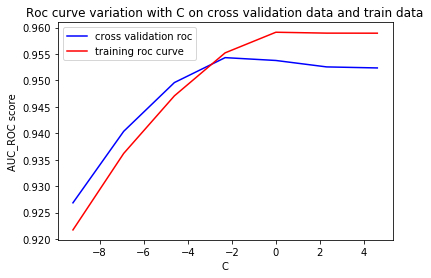

In [147]:
plt.plot(alpha1,roc_auc_cv,'-b', label='cross validation roc')
plt.plot(alpha1,roc_auc_train,'r',label="training roc curve")
plt.title("Roc curve variation with C on cross validation data and train data")
plt.xlabel("C")
plt.ylabel("AUC_ROC score")
plt.legend(loc='upper left')
plt.show()

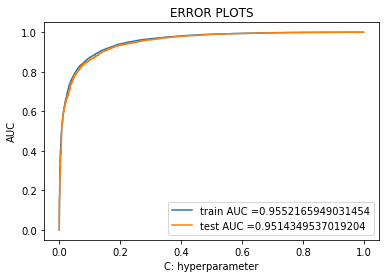

In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
nv = MNB(C=.1,penalty= 'l2')
nv.fit(enc_X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, nv.predict_proba(enc_X_train)[:,1])
test_fpr, test_tpr, thresholds1 = roc_curve(y_test, nv.predict_proba(enc_X_test)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

AUC score on test data: 0.8157915029876679
AUC score on the training data: 0.8166056489609113
Train confusion matrix
Test confusion matrix


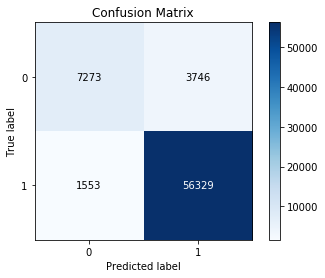

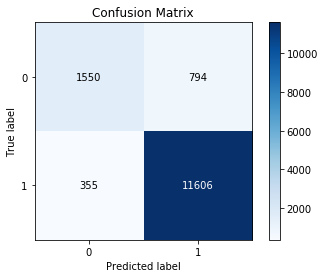

In [149]:
prediction1 = nv.predict(enc_X_test)
score1 = AUC(y_test,prediction1)
prediction2 = nv.predict(enc_X_train)
score2 = AUC(y_train,prediction2)
print("AUC score on test data:",score1)
print("AUC score on the training data:",score2)
print("Train confusion matrix")
skplt.plot_confusion_matrix(y_train,nv.predict(enc_X_train))
print("Test confusion matrix")
skplt.plot_confusion_matrix(y_test,nv.predict(enc_X_test))

In [151]:
print("Train Accuracy of the Model : ",accuracy_score(y_train,nv.predict(enc_X_train)))
print("Test Accuracy of the Model: ",accuracy_score(y_test,nv.predict(enc_X_test)))

Train Accuracy of the Model :  0.9230925530834095
Test Accuracy of the Model:  0.9196784341139461


Conclusions :
-> We are getting almost equal AUC as we are getting without dimensionality reduction using encode decoder.